In [180]:
from contextlib import contextmanager
import numpy as np
import matplotlib.pyplot as plt
import abc

In [181]:
class Curve(abc.ABC):
    """Curve is the abtract base class for curve representations"""
    @abc.abstractmethod
    def fn(self, x, y):
        pass
    
    def plot(self, axes=None, grid=np.ogrid[-5:5:100j, -5:5:100j], **kwargs):
        y, x = grid
        axes = axes or plt.axes()
        axes.contour(x.ravel(), y.ravel(), self.fn(x, y), [0], **kwargs)

In [182]:
class EllipticCurve(Curve):
    """EllipticCurve is the abtract base class for elliptic curve representations"""
    @abc.abstractmethod
    def zeroes(self, x):
        pass
    
    def point_at_x(self, x, positive=True):
        ys = self.zeroes(x)
        
        if not ys:
            return None
        
        if len(ys) == 1:
            return (x, ys[0])
        
        return (x, ys[0]) if positive else (x, ys[1])
    
    @abc.abstractmethod
    def inverse(self, p):
        pass

In [183]:
class Identity:
    pass

In [184]:
class Line(Curve):
    """Line is a utility class to help plot lines on the graph (e.g. for visualizaing the curve additions law)"""
    def __init__(self, point, slope):
        self.point = point
        self.slope = slope
    
    @classmethod
    def through(cls, p, q):
        slope = (q[1] - p[1]) / (q[0] - p[0])
        return cls(p, slope)
    
    @classmethod
    def xline(cls, p):
        return cls(p, None)
    
    @classmethod
    def yline(cls, p):
        return cls(p, 0)
    
    def fn(self, x, y):
        if self.slope is not None:
            return y - ((x - self.point[0]) * self.slope + self.point[1])
        else:
            return (y*0) - (x - self.point[0])

In [185]:
class Hyperbole(Curve):
    """Hyberbole which passes through (-1, 0) and has asymtotes parallel to the coordinate access
    
    Used in the circle and Edwards curve addition laws.
    
    Reference:
        The Group Law for Edwards Curves: https://arxiv.org/pdf/1610.05278.pdf
    """
    def __init__(self, a, b):
        # Note: a is p and b is q from arxiv.org/abs/1610.05278 Eq. 2
        self.a = a
        self.b = b
    
    @classmethod
    def through(cls, p, q):
        # TODO: Find some more efficient and complete formulas to solve for a and b
        if p[1] == 0 and q[1] == 0:
            raise ValueError("y_p and y_q equal to zero is unsupported")

        # Formulas need to use whichever y is non-zero.
        (i, j) = (q, p) if p[1] != 0 else (p, q)
        (yi, xi) = i
        (yj, xj) = j
        
        # Solve for a from the two points, the for b with a and one point.
        b = ((xi - xj) * yi) / ((xj + 1) * yi/yj - (xi + 1))
        a = -(xj + b*(xj + 1) / yj)

        return cls(a, b)
    
    def fn(self, x, y):
        return x*y + self.a*x + self.b*(y + 1)

In [186]:
class ShortWeierstrassCurve(EllipticCurve):
        def __init__(self, a, b):
            self.a = a
            self.b = b
            
        def fn(self, x, y):
            return np.power(y, 2) - np.power(x, 3) - x * self.a - self.b
        
        def zeroes(self, x):
            y_squared = np.power(x, 3) - x * self.a - self.b
            if y_squared < 0:
                return []
            if y_squared == 0:
                return [0.0]
            else:
                y = np.sqrt(y_squared)
                return [y, -y]
                
        def inverse(self, p):
            return (p[0], -p[1])

In [187]:
class MontgomeryCurve(EllipticCurve):
        """
        Reference:
            Montgomery Curves and their Arithmatic: https://eprint.iacr.org/2017/212
        """
        IDENTITY = Identity()
    
        def __init__(self, a, b):
            if a**2 == 4 or b == 0:
                raise ValueError('Invalid paramters: A^2 = 4 or B = 0')
                
            self.a = a
            self.b = b
            
        def fn(self, x, y):
            return np.power(y, 2) * self.b - (np.power(x, 3) + np.power(x, 2) * self.a + x)
        
        def zeroes(self, x):
            y_squared = (np.power(x, 3) + np.power(x, 2) * self.a + x) / self.b
            if y_squared < 0:
                return []
            if y_squared == 0:
                return [0.0]
            else:
                y = np.sqrt(y_squared)
                return [y, -y]
            
        def add(self, p, q):
            (xp, yp) = p
            (xq, yq) = q
            
            # Three cases correspond to adding, doubling, and adding with inverse.
            if xp != xq:
                lam = (yq - yp)/(xq - xp)
            elif yp == yq:
                lam = (3 * np.power(xp, 2) + 2 * self.a * xp + 1)/(2 * self.b * yp)
            else:
                return self.IDENTITY
            
            x_add = self.b * np.power(lam, 2) - (xp + xq) - self.a
            y_add = lam * (xp - x_add) - yp
            return (x_add, y_add)
        
        def inverse(self, p):
            return (p[0], -p[1])    

In [188]:
class TwistedEdwardsCurve(EllipticCurve):
        def __init__(self, a, d):
            if a == 0 or d == 0 or a == d:
                raise ValueError('Invalid parameters: a and d must be distinct and non-zero')
            self.a = a
            self.d = d
            
        def fn(self, x, y):
            return (self.a * np.power(x, 2) +  np.power(y, 2)) - (1 + self.d * np.power(x, 2) * np.power(y, 2))
        
        def zeroes(self, x):
            y_squared = (1 - self.a*np.power(x, 2)) / (1 - self.d*np.power(x, 2))
            if y_squared < 0:
                return []
            if y_squared == 0:
                return [0.0]
            else:
                y = np.sqrt(y_squared)
                return [y, -y]
            
        def add(self, p, q):
            (xp, yp) = p
            (xq, yq) = q
            x_add = (xp*yq + yp*xq) / (1 + self.d*xp*xq*yp*yq)
            y_add = (yp*yq - self.a*xp*xq) / (1 - self.d*xp*xq*yp*yq)
            return (x_add, y_add)
        
        def inverse(self, p):
            return (-p[0], p[1])

In [189]:
class Circle(EllipticCurve):
        """Unit circle"""
        def fn(self, x, y):
            return 1 - (np.power(x, 2) +  np.power(y, 2))
        
        def zeroes(self, x):
            if x < -1 or 1 < x:
                return []

            y = np.sqrt(1 - np.power(x, 2))
            return [y, -y]
        
        def add(self, p, q):
            (xp, yp) = p
            (xq, yq) = q
            return (xp*yq + yp*xq, yp*yq - xp*xq)
        
        def inverse(self, p):
            return (-p[0], p[1])

In [190]:
@contextmanager
def curve_plot(*args, **kwargs):
    # Set up the figure with default or override options.
    figure_options = {
        'figsize': (15, 15)
    }
    figure_options.update(kwargs)
    figure = plt.figure(*args, **figure_options)
    axes = plt.axes()
    
    # If yield raises, allow the fault.
    yield (figure, axes)
    
    # Add elements to figure after content.
    axes.grid()
    #plt.show()
    

## Curve Shapes over Reals

_TODO: Add `ipywidgets` so user can play with curve shapes intuitively_

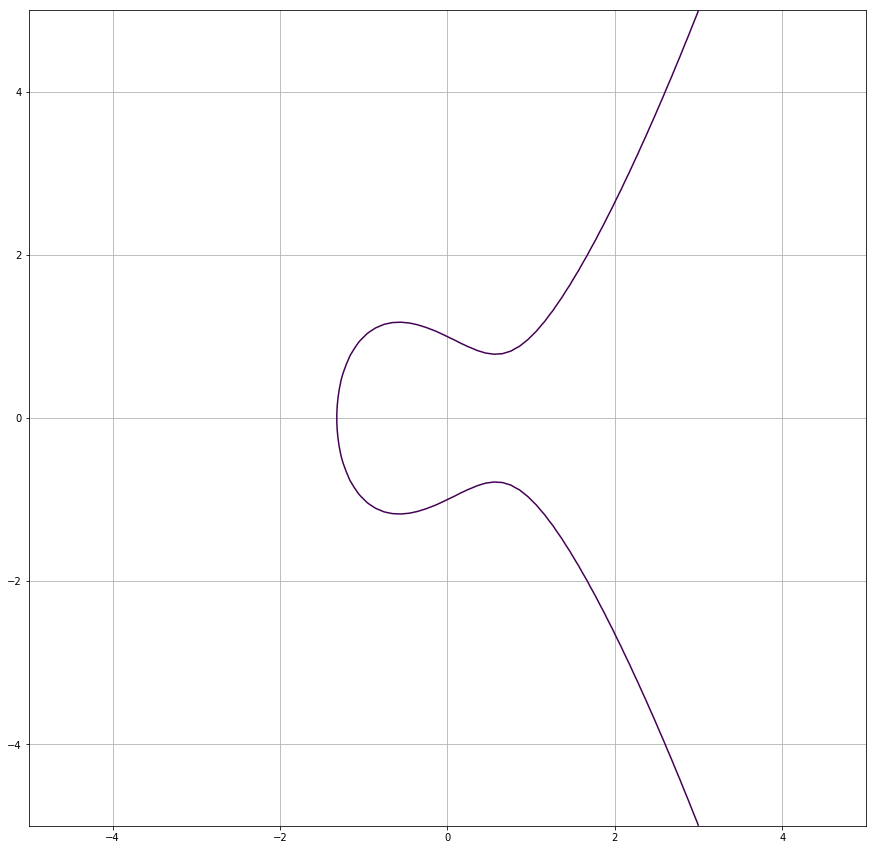

In [191]:
with curve_plot() as (_, axes):
    ShortWeierstrassCurve(-1, 1).plot(axes=axes)

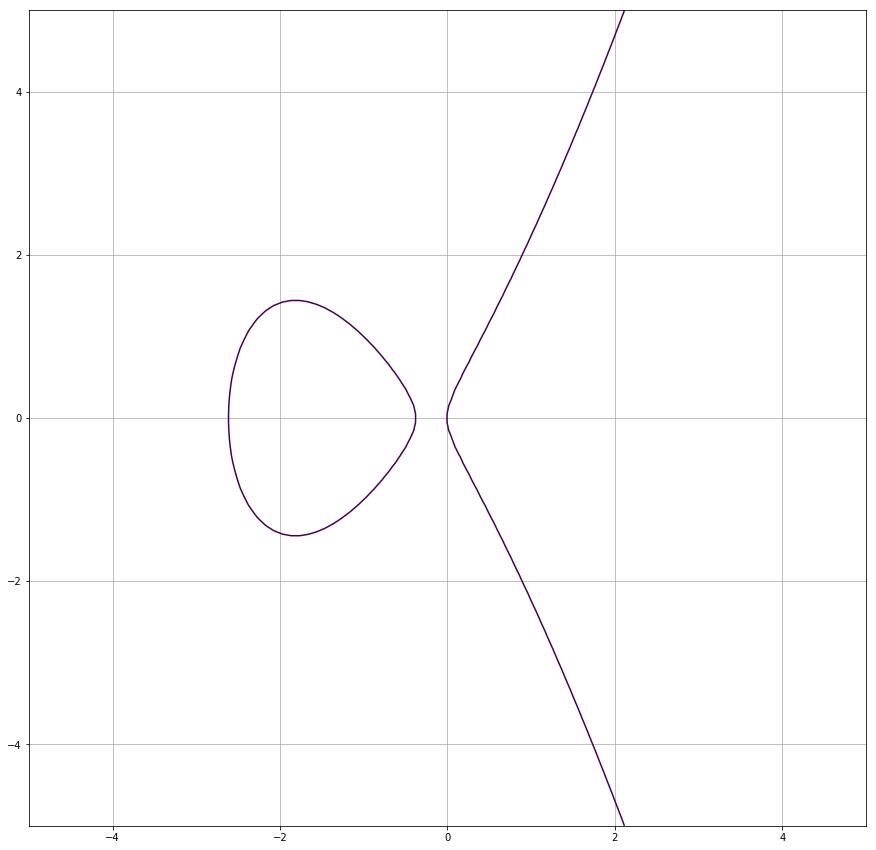

In [192]:
with curve_plot() as (_, axes):
    MontgomeryCurve(3, 1).plot(axes=axes)

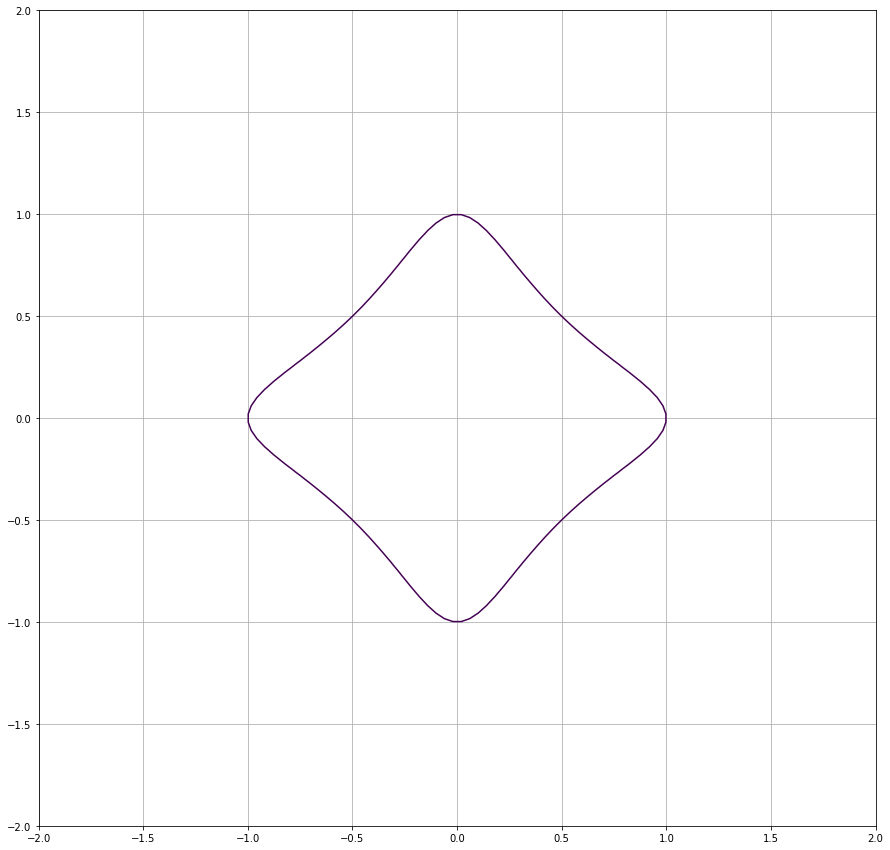

In [193]:
with curve_plot() as (_, axes):
    TwistedEdwardsCurve(1, -8).plot(axes=axes, grid=np.ogrid[-2:2:100j, -2:2:100j])

## Addition Laws

In [194]:
MontgomeryCurve(-1, 1).zeroes(1)

[1.0, -1.0]

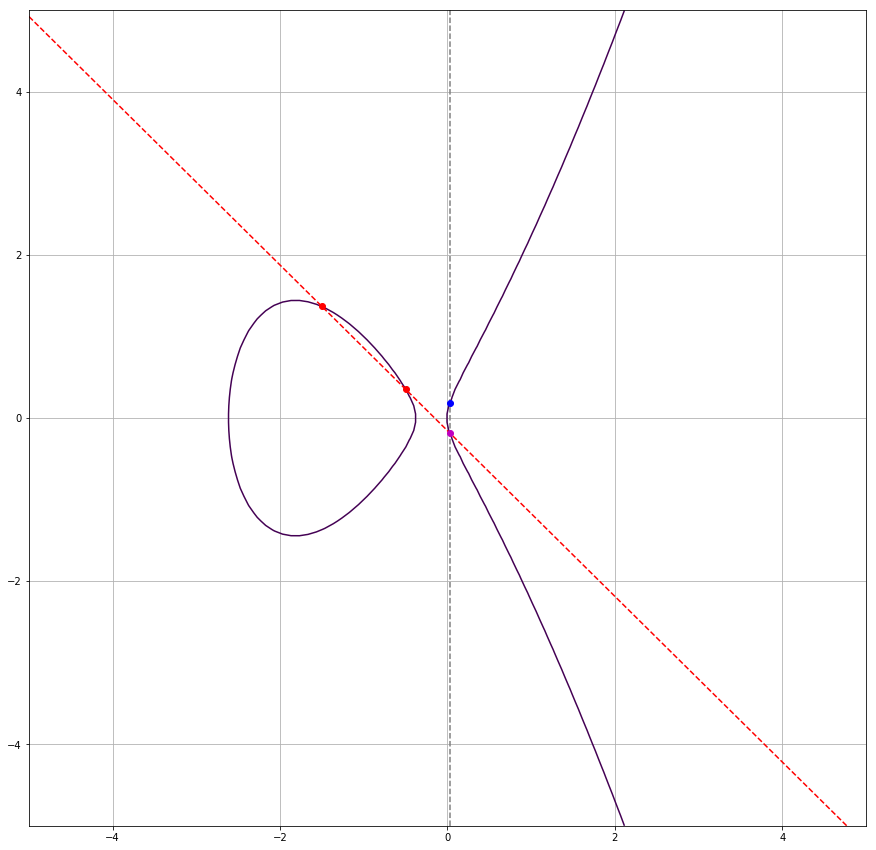

In [195]:
curve = MontgomeryCurve(3, 1)
p = curve.point_at_x(-1.5, positive=True)
q = curve.point_at_x(-0.5, positive=True)
r = curve.add(p, q)

with curve_plot() as (_, axes):
    curve.plot(axes=axes)
    axes.plot(*p, 'ro')
    axes.plot(*q, 'ro')
    axes.plot(*r, 'bo')
    axes.plot(*curve.inverse(r), 'mo')
    Line.through(p, q).plot(axes=axes, linestyles='dashed', colors='red')
    Line.xline(r).plot(axes=axes, linestyles='dashed', colors='grey')

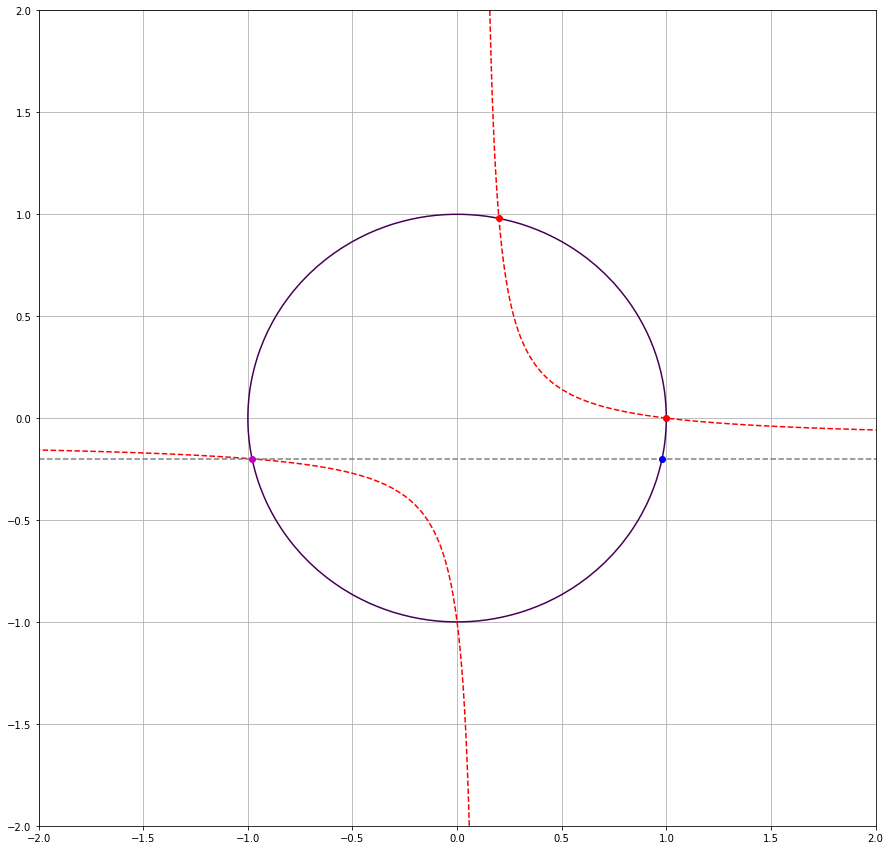

In [201]:
curve = Circle()
p = curve.point_at_x(0.2, positive=True)
q = curve.point_at_x(1, positive=True)
r = curve.add(p, q)

# TODO: Additionally code up the functions to draw the angle (from vector (0, 1)) addition forumalation.
grid = np.ogrid[-2:2:100j, -2:2:100j]

with curve_plot() as (_, axes):
    curve.plot(axes=axes, grid=grid)
    axes.plot(*p, 'or')
    axes.plot(*q, 'or')
    axes.plot(*r, 'ob')
    axes.plot(*curve.inverse(r), 'om')
    Hyperbole.through(p, q).plot(axes=axes, linestyles='dashed', colors='red', grid=grid)
    Line.yline(r).plot(axes=axes, linestyles='dashed', colors='grey', grid=grid)

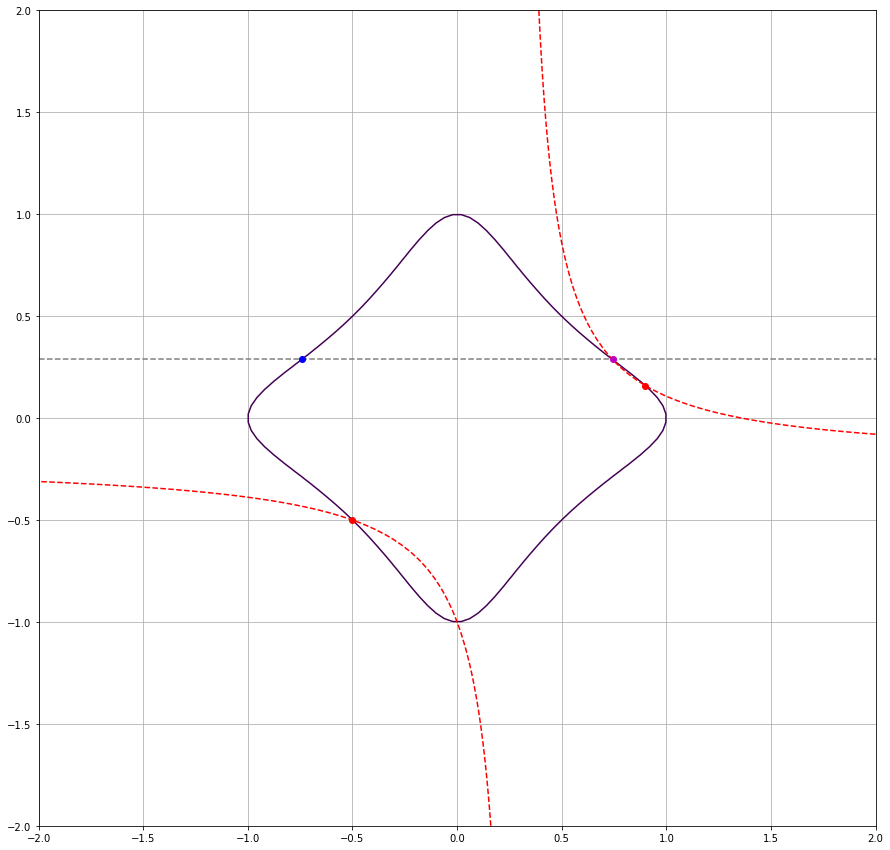

In [200]:
curve = TwistedEdwardsCurve(1, -8)
p = curve.point_at_x(-0.5, positive=False)
q = curve.point_at_x(0.9, positive=True)
r = curve.add(p, q)

grid = np.ogrid[-2:2:100j, -2:2:100j]

with curve_plot() as (_, axes):
    curve.plot(axes=axes, grid=grid)
    axes.plot(*p, 'or')
    axes.plot(*q, 'or')
    axes.plot(*r, 'ob')
    axes.plot(*curve.inverse(r), 'om')
    Hyperbole.through(p, q).plot(axes=axes, linestyles='dashed', colors='red', grid=grid)
    Line.yline(r).plot(axes=axes, linestyles='dashed', colors='grey', grid=grid)